In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt

import os, sys
sys.path.append("yamnet/")

import features as features_lib
import params as params
import yamnet as yamnet_model
import tensorflow.compat.v1 as tf

from librosa.core import load
from librosa.feature import melspectrogram

In [3]:
class modelYamnet:
    def __init__(self, sr=22050):
        self.class_names = yamnet_model.class_names('yamnet/yamnet_class_map.csv')
        params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.
        self.graph = tf.Graph()
        params.SAMPLE_RATE = sr
        with self.graph.as_default():
            self.yamnet = yamnet_model.yamnet_frames_model(params)
            self.yamnet.load_weights('yamnet/yamnet.h5')
            
    def predict_music(self, wav_file_name):
        wav_data, sr = load(wav_file_name)
        with self.graph.as_default():
            scores, spectrogram = self.yamnet.predict(np.reshape(wav_data, [1, -1]), steps=1)
        return wav_data, scores, spectrogram

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
class_names = yamnet_model.class_names('yamnet/yamnet_class_map.csv')
model_yamnet = yamnet_model.yamnet_frames_model(params)
model_yamnet.load_weights('yamnet/yamnet.h5')
model_yamnet.trainable = False

In [8]:
def fine_tuning_model(model_yamnet):
    layer_input = layers.Input(shape=[params.PATCH_FRAMES, params.PATCH_BANDS])
    x = layer_input
    for layer in model_yamnet.layers[63:-2]:
        x = layer(x)
    predictions = model_yamnet.layers[-2](model_yamnet.layers[-1](x))

    logits2 = layers.Dense(units=params.NUM_CLASSES2, use_bias=True)(x)
    predictions2 = layers.Activation(
        name=params.EXAMPLE_PREDICTIONS_LAYER_NAME2,
        activation=params.CLASSIFIER_ACTIVATION)(logits2)

    model_train = Model(layer_input, predictions2)

    waveform = layers.Input(batch_shape=(1, None))
    spectrogram = features_lib.waveform_to_log_mel_spectrogram(
        tf.squeeze(waveform, axis=0), params)
    patches = features_lib.spectrogram_to_patches(spectrogram, params)
    model_prediction = Model(waveform, [Model(layer_input, predictions)(patches), spectrogram, model_train(patches)])
    
    return model_train, model_prediction

In [9]:
model_train, model_prediction = fine_tuning_model(model_yamnet)

In [6]:
wav_file_name = 'music/Stranger Things (Extended).mp3'
wav_data, sr = load(wav_file_name)

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [11]:
import features as features_lib

spectrogram = features_lib.waveform_to_log_mel_spectrogram(
        tf.squeeze([wav_data], axis=0), params)
patches = features_lib.spectrogram_to_patches(spectrogram, params)

In [7]:
np.reshape(wav_data, [1, -1]).shape

(1, 7182144)

In [4]:
model.yamnet.summary()

Model: "yamnet_frames"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None,)]            0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_log_mel_features/st [(1,)]               0           tf_op_layer_Squeeze[0][0]        
__________________________________________________________________________________________________
tf_op_layer_log_mel_features/st [(0,), (1,), (0,)]   0           tf_op_layer_log_mel_features/stft
______________________________________________________________________________________

In [16]:
wav_file_name = 'music/Stranger Things (Extended).mp3'
wav_data, scores, spectrogram = model.predict_music(wav_file_name)

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [9]:
with model.graph.as_default():
    scores, spectrogram = model.yamnet.predict(np.reshape(wav_data, [1, -1]), steps=10)
return wav_data, scores, spectrogram

SyntaxError: 'return' outside function (<ipython-input-9-ff322bfb24b0>, line 3)

In [ ]:
scores.shape

In [ ]:
ipd.Audio(wav_data.T, rate=sr)

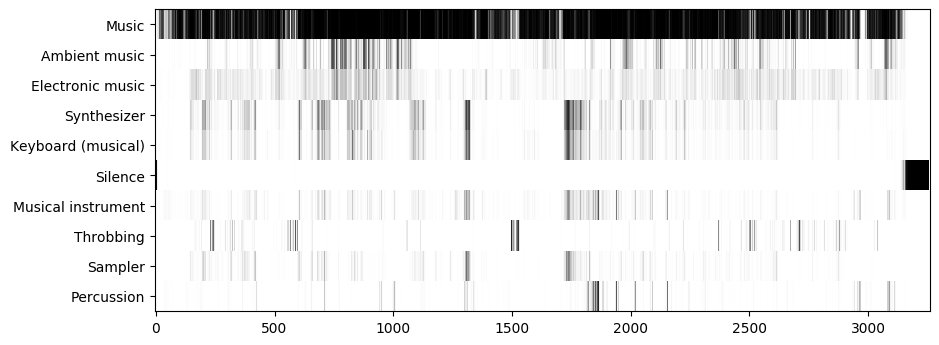

In [8]:
draw_prediction(model.class_names, scores)

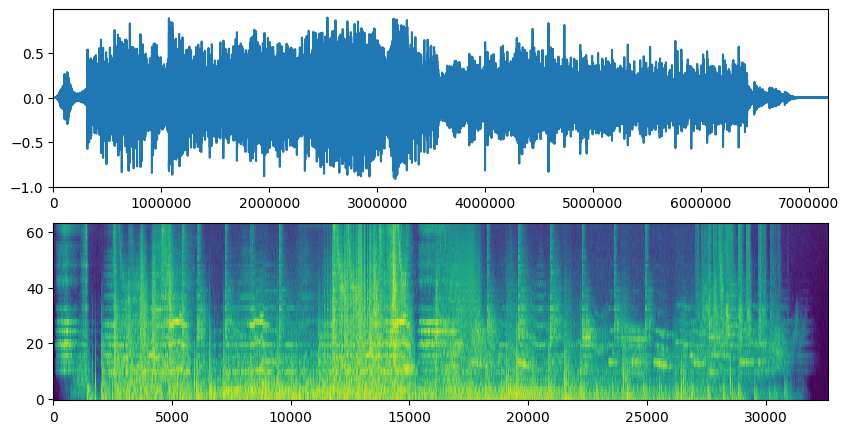

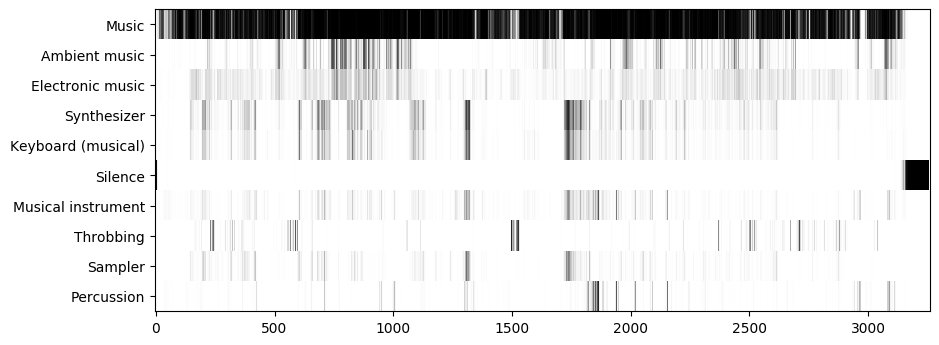

In [17]:
draw_result(wav_data, model.class_names, scores, spectrogram)